In [1]:
import requests
import os

import pandas as pd
import geopandas as gpd
from fiona.crs import from_epsg
import pyproj
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union

import matplotlib.pyplot as plt

import json
from pandas.io.json import json_normalize

from time import sleep, time
from IPython.core.display import clear_output

from itertools import product
from ast import literal_eval

%matplotlib inline

In [2]:
#Set the folder for APIKEY.py file
%cd "/home/jovyan/personal"

#Load API Keys
from APIKEY import GoogleKey_WeiYun

#Go back to previuos folder
%cd -

/home/jovyan/personal
/home/jovyan/nyu/Spring 2019/Urban Science Intensive I/Getting to Zero Capstone_/Data/Google Places


### Read place types

Get place types, and filter only the ones with assigned sop_variables. This list needs to be checked, I skipped place types where I'm not sure they will be useful.

In [3]:
place_types = pd.read_excel('place_types.xlsx')
place_types.head()

,type,sop_variable,skip
0,accounting,NaN,NaN
1,airport,NaN,NaN
2,amusement_park,recoher,y
3,aquarium,recoher,y
4,art_gallery,artgllry,NaN


In [4]:
place_types_fetch = place_types[~place_types.sop_variable.isnull() & place_types.skip.isnull()]
place_types_fetch.head()

,type,sop_variable,skip
4,art_gallery,artgllry,NaN
7,bank,financl,NaN
8,bar,barsclub,NaN
10,bicycle_store,bikeretl,NaN
11,book_store,libbkstr,NaN


In [5]:
len(place_types_fetch)

45

### Read NYC Neighborhoods

In [6]:
neighborhoods = gpd.read_file('Neighborhood Tabulation Areas.geojson')
neighborhoods.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,BK88,54005019.0709,047,Borough Park,39247.2280277,Brooklyn,3,(POLYGON ((-73.97604935657381 40.6312759056467...
1,QN51,52488276.867,081,Murray Hill,33266.9049948,Queens,4,(POLYGON ((-73.80379022888246 40.7756101117924...
2,QN27,19726845.4194,081,East Elmhurst,19816.7122926,Queens,4,(POLYGON ((-73.86109724401859 40.7636644770877...
3,QN07,22887772.8652,081,Hollis,20976.3355739,Queens,4,(POLYGON ((-73.75725671509139 40.7181386016625...
4,MN06,10647077.4989,061,Manhattanville,17040.6854134,Manhattan,1,(POLYGON ((-73.94607828674226 40.8212632160619...


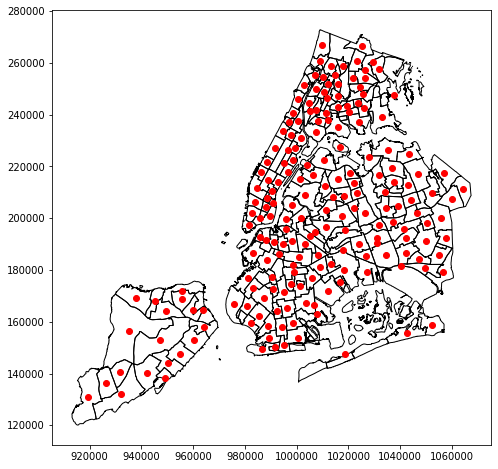

In [7]:
fig, ax = plt.subplots(figsize=(12,8))

neighborhoods.to_crs(epsg=2263).plot(ax=ax, facecolor='None', edgecolor='k')

neighborhoods.centroid.to_crs(epsg=2263).plot(ax=ax, color='red')

plt.show()

### Read Google Places and preprocess

Read CSVs into one dataframe

In [47]:
df = pd.concat((pd.read_csv('raw/'+f) for f in os.listdir('raw') if ('doctor' not in f) & f.endswith('csv')), ignore_index=True, sort=False)
df.head()

,geometry.location.lat,geometry.location.lng,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,icon,id,name,opening_hours.open_now,...,plus_code.compound_code,plus_code.global_code,rating,reference,scope,types,user_ratings_total,vicinity,price_level,permanently_closed
0,40.502759,-74.246993,40.504138,-74.245494,40.501440,-74.248192,https://maps.gstatic.com/mapfiles/place_api/ic...,f7826b993000af4ec5cbf340e11b67ed2e92f22c,J T Public Adjuster Inc,NaN,...,"GQ33+46 New York, United States",87G7GQ33+46,NaN,ChIJ0XvtK5fKw4kRfPXvpajjFSI,NaN,"['insurance_agency', 'point_of_interest', 'est...",NaN,"230 Carteret Street, Staten Island",NaN,NaN
1,40.502161,-74.249050,40.503483,-74.247836,40.500785,-74.250534,https://maps.gstatic.com/mapfiles/place_api/ic...,bd255395052f66eda04fdab3a728c0097046362f,Exclusive Title Agency of NY,NaN,...,"GQ22+V9 New York, United States",87G7GQ22+V9,NaN,ChIJS0HiGZHKw4kRhiMIwK8971M,GOOGLE,"['insurance_agency', 'point_of_interest', 'est...",NaN,"207 Connecticut Street, Staten Island",NaN,NaN
2,40.499018,-74.240897,40.500395,-74.239407,40.497697,-74.242105,https://maps.gstatic.com/mapfiles/place_api/ic...,369fdc8a5681d9b02dc78b0ec7595a4090b83160,Neglia's Services,NaN,...,"FQX5+JJ New York, United States",87G7FQX5+JJ,NaN,ChIJV24DB77Kw4kR9HKs0QnTl00,GOOGLE,"['insurance_agency', 'point_of_interest', 'est...",NaN,"448 Manhattan Street, Staten Island",NaN,NaN
3,40.509209,-74.247310,40.510501,-74.246065,40.507803,-74.248763,https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,Sovereign Facilities Inc,NaN,...,"GQ53+M3 New York, United States",87G7GQ53+M3,NaN,ChIJd2B94pvKw4kReNkyE7-YJsI,GOOGLE,"['insurance_agency', 'point_of_interest', 'est...",NaN,"242 Main Street, Staten Island",NaN,NaN
4,40.510422,-74.248814,40.511724,-74.247431,40.509026,-74.250129,https://maps.gstatic.com/mapfiles/place_api/ic...,90808be3a82b938d4d43140a2a765e42fe4b155c,Cnr Agency Inc,NaN,...,"GQ62+5F New York, United States",87G7GQ62+5F,NaN,ChIJHYu9dJzKw4kRLDcVS5kfWIk,GOOGLE,"['insurance_agency', 'point_of_interest', 'est...",NaN,"449 Craig Avenue, Staten Island",NaN,NaN


In [48]:
len(df)

386121

Check duplicates

In [49]:
df.place_id.duplicated().sum()

249144

**Note:** Each place can have more than one type, and to cover all the city lots of areas got queried more than once.

In [50]:
df = df[~df.place_id.duplicated()]
len(df)

136977

In [51]:
df['geometry'] = df.apply(lambda x: Point(x['geometry.location.lng'], x['geometry.location.lat']), axis=1)
gdf = gpd.GeoDataFrame(df)
gdf.crs = from_epsg(4326)

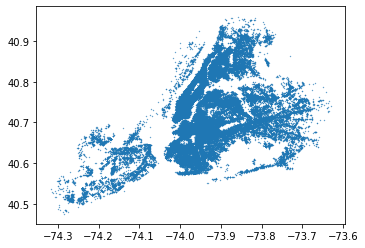

In [52]:
gdf.plot(markersize=0.1)

Need to get rid of points outside of NYC

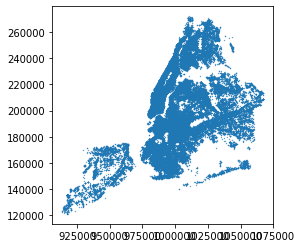

In [53]:
gdf = gpd.sjoin(gdf.to_crs(epsg=2263), neighborhoods.to_crs(epsg=2263), how='inner')
gdf.plot(markersize=0.1)

Transform types column (list) into separate columns.

In [62]:
gdf.columns

Index(['geometry.location.lat', 'geometry.location.lng',
       'geometry.viewport.northeast.lat', 'geometry.viewport.northeast.lng',
       'geometry.viewport.southwest.lat', 'geometry.viewport.southwest.lng',
       'icon', 'id', 'name', 'opening_hours.open_now', 'photos', 'place_id',
       'plus_code.compound_code', 'plus_code.global_code', 'rating',
       'reference', 'scope', 'types', 'user_ratings_total', 'vicinity',
       'price_level', 'permanently_closed', 'geometry', 'index_right',
       'ntacode', 'shape_area', 'county_fips', 'ntaname', 'shape_leng',
       'boro_name', 'boro_code'],
      dtype='object')

In [56]:
gdf.types.head()

0    ['insurance_agency', 'point_of_interest', 'est...
1    ['insurance_agency', 'point_of_interest', 'est...
2    ['insurance_agency', 'point_of_interest', 'est...
3    ['insurance_agency', 'point_of_interest', 'est...
4    ['insurance_agency', 'point_of_interest', 'est...
Name: types, dtype: object

In [63]:
types = pd.get_dummies(gdf.types.apply(lambda x: pd.Series(literal_eval(x))).stack()).sum(level=0)
types.head()

,accounting,art_gallery,atm,bakery,bank,bar,beauty_salon,bicycle_store,book_store,bowling_alley,...,spa,stadium,storage,store,supermarket,synagogue,transit_station,travel_agency,university,veterinary_care
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
types.columns

Index(['accounting', 'art_gallery', 'atm', 'bakery', 'bank', 'bar',
       'beauty_salon', 'bicycle_store', 'book_store', 'bowling_alley',
       'bus_station', 'cafe', 'campground', 'car_dealer', 'car_rental',
       'car_repair', 'car_wash', 'casino', 'cemetery', 'church', 'city_hall',
       'clothing_store', 'convenience_store', 'courthouse', 'dentist',
       'department_store', 'doctor', 'electrician', 'electronics_store',
       'embassy', 'establishment', 'finance', 'fire_station', 'florist',
       'food', 'funeral_home', 'furniture_store', 'gas_station',
       'general_contractor', 'grocery_or_supermarket', 'gym', 'hair_care',
       'hardware_store', 'health', 'hindu_temple', 'home_goods_store',
       'hospital', 'insurance_agency', 'jewelry_store', 'laundry', 'lawyer',
       'library', 'liquor_store', 'local_government_office', 'locksmith',
       'lodging', 'meal_delivery', 'meal_takeaway', 'mosque', 'movie_rental',
       'movie_theater', 'moving_company', 'museum', 'n

In [67]:
gdf = pd.concat([gdf, types], axis=1)

In [76]:
gdf.iloc[65463]

geometry.location.lat                                                        40.7548
geometry.location.lng                                                        -73.992
geometry.viewport.northeast.lat                                              40.7562
geometry.viewport.northeast.lng                                             -73.9907
geometry.viewport.southwest.lat                                              40.7535
geometry.viewport.southwest.lng                                             -73.9934
icon                               https://maps.gstatic.com/mapfiles/place_api/ic...
id                                          ab97d2aeabbd369cffca222a0910bc11c70313a3
name                                        City Sewing Machine Corp II ( Showroom )
opening_hours.open_now                                                         False
photos                             [{'height': 640, 'html_attributions': ['<a hre...
place_id                                                 ChIJBylI

In [77]:
#gdf.to_file('out/Google_Places_NYC.geojson', driver='GeoJSON')
gdf.to_csv('out/Google_Places_NYC.csv', index=False)